In [1]:
!pip install fastai nbdev --upgrade -q

     |████████████████████████████████| 194kB 8.7MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 


In [2]:
from fastai.vision.all import *
import requests
from PIL import Image
import random
from tqdm.notebook import tqdm

This notebook does a very quick/crude experiment to compare the speed of doing image resize operations done via a IIIF requests compared to working with full size images and resizing them in your training loop. 

In [3]:
doc(Resize)

Download a single image in full size as our local image

In [4]:
!wget  https://stacks.stanford.edu/image/iiif/hg676jb4964%2F0380_796-44/full/max/0/default.jpg

--2020-10-06 11:45:24--  https://stacks.stanford.edu/image/iiif/hg676jb4964%2F0380_796-44/full/max/0/default.jpg
Resolving stacks.stanford.edu (stacks.stanford.edu)... 171.67.37.91
Connecting to stacks.stanford.edu (stacks.stanford.edu)|171.67.37.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘default.jpg’

default.jpg             [                <=> ]   2.55M   725KB/s    in 4.8s    

2020-10-06 11:45:30 (541 KB/s) - ‘default.jpg’ saved [2673137]



Since we only have one image we create some fake training data by copying the image 500 times and then assigning a dummy label of 'a' or 'b'

In [5]:
for i,_ in enumerate(tqdm(range(500))):
  im = Image.open('default.jpg')
  im.save(f"{random.choice(['a','b'])}_{i}.jpg")

Remove the original image

In [6]:
Path('default.jpg').unlink()

Use get_image files to grab all of the newly created images and then put them into a dataframe and create a column for the dummy labels.

In [7]:
image_files = get_image_files('.')

In [8]:
df  = pd.DataFrame(image_files.items, columns=['fname'])

In [9]:
df['label'] = df.fname.apply(lambda x: (x.name)[0])

We create a new column which contains a 250 by 250 iiif request url for the same image.



In [10]:
df['iif_url'] = 'https://stacks.stanford.edu/image/iiif/hg676jb4964%2F0380_796-44/full/250,250/0/default.jpg'

Create two datablocks one for local images, and one for images loaded via IIIF

In [11]:
local = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(valid_pct=0.2),
    get_x=Pipeline([ColReader('fname')]),
    get_y=ColReader('label'),
    item_tfms=Resize(250, method=ResizeMethod.Squish))

You can see that the actual process of consuming IIIf images is fairly simple. We just create a new function which downloads the image and returns a PIL Image. We then pass this into a pipeline for `get_x` which first grabs the column containing the URL

In [12]:
import requests
def get_im(x):
    with requests.get(x,timeout=30) as r:
        return PILImage.create(io.BytesIO(r.content))

iiif = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(valid_pct=0.2),
    get_x=Pipeline([ColReader('iif_url'),get_im]),
    get_y=ColReader('label'))

View both of the datasets to check they *look* similar. I haven't verified the similarities of these transformations properly.

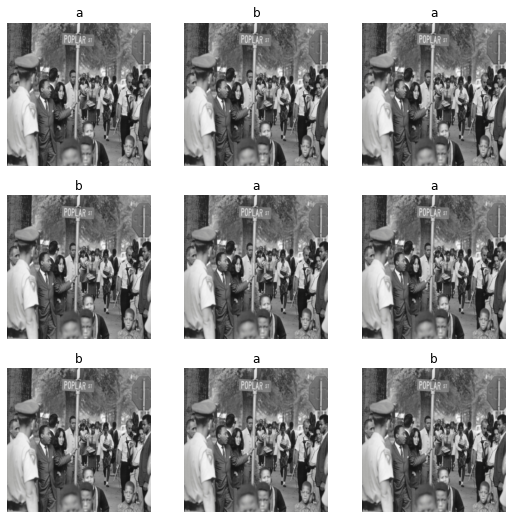

In [13]:
dls_local = local.dataloaders(df, bs=32)
dls_local.show_batch()

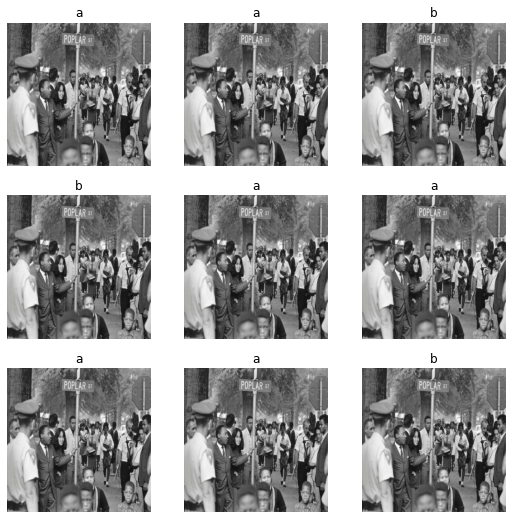

In [14]:
dls_iif = iiif.dataloaders(df, bs=32)
dls_iif.show_batch()

Now create two learners with the same paramters execpet for the source of the training data and time how long it takes to train for 5 epochs.

In [15]:
%%time
learn_local = cnn_learner(dls_local, resnet18).to_fp16()
learn_local.fit(5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,time
0,0.690308,4.715998,01:29
1,0.706665,29.314219,01:29
2,0.775864,52.037540,01:27
3,0.834483,121.997498,01:28
4,0.863102,282.704987,01:29


CPU times: user 3.4 s, sys: 1.74 s, total: 5.14 s
Wall time: 7min 25s


In [16]:
%%time
learn_iiif = cnn_learner(dls_iif, resnet18).to_fp16()
learn_iiif.fit(5)

epoch,train_loss,valid_loss,time
0,0.720346,2.533968,01:45
1,0.723095,23.081017,01:42
2,0.768923,115.687500,01:46
3,0.849878,10.575000,01:44
4,0.877042,491.177490,01:46


CPU times: user 2.68 s, sys: 1.71 s, total: 4.39 s
Wall time: 8min 45s


As we would probably expect the local version is faster but not actually by as much as I would expect. 

This isn't a suggestion to actually use this in practice, this was just a way of satisfying my curioisity about the potential differences in training speed for both approaches. 